In [1]:
import numpy as np
import pandas as pd
import acquire as a 
import prepare as p
import wrangle_zillow as wz
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer

# Zillow

For the following, iterate through the steps you would take to create functions: Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions.

You will have a zillow.ipynb file and a helper file for each section in the pipeline.

### acquire & summarize

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid.
- Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [2]:
#write a query (this is from sql)

In [3]:
sql_query = '''
SELECT prop.parcelid,  prop.basementsqft, bathroomcnt, bedroomcnt, decktypeid, calculatedfinishedsquarefeet,
fips, fireplacecnt, garagecarcnt, hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt,
yearbuilt, numberofstories, prop.airconditioningtypeid, airconditioningdesc, prop.architecturalstyletypeid,
architecturalstyledesc, prop.buildingclasstypeid, buildingclassdesc, prop.heatingorsystemtypeid,
heatingorsystemdesc, prop.storytypeid, storydesc, prop.propertylandusetypeid, propertylandusedesc, 
prop.typeconstructiontypeid, typeconstructiondesc, unitcnt, taxvaluedollarcnt, taxamount, logerror, transactiondate 
from properties_2017 as prop
join predictions_2017 as pred USING (parcelid)
LEFT JOIN airconditioningtype USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
WHERE transactiondate like '2017%' 
AND latitude >= 0 AND longitude <= 0;
'''

In [4]:
sql_query2 ='''
SELECT prop.parcelid,  prop.basementsqft, bathroomcnt, bedroomcnt, decktypeid, calculatedfinishedsquarefeet,
fips, fireplacecnt, garagecarcnt, hashottuborspa, latitude, longitude, lotsizesquarefeet, poolcnt,
yearbuilt, numberofstories, prop.airconditioningtypeid, airconditioningdesc, prop.architecturalstyletypeid,
architecturalstyledesc, prop.buildingclasstypeid, buildingclassdesc, prop.heatingorsystemtypeid,
heatingorsystemdesc, prop.storytypeid, storydesc, prop.propertylandusetypeid, propertylandusedesc, 
prop.typeconstructiontypeid, typeconstructiondesc, unitcnt, taxvaluedollarcnt, taxamount, logerror, transactiondate 
from properties_2017 as prop
right join predictions_2017 as pred USING (parcelid)
LEFT JOIN airconditioningtype USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
WHERE transactiondate like '2017%'  
AND latitude != 'NULL' AND longitude != 'NULL';
'''

In [5]:
#acquire my df
df= a.get_data_from_sql('zillow',sql_query2)

In [6]:
df.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,storydesc,propertylandusetypeid,propertylandusedesc,typeconstructiontypeid,typeconstructiondesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,1023282.0,11013.72,0.025595,2017-01-01
1,17052889,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,464000.0,5672.48,0.055619,2017-01-01
2,14186244,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,564778.0,6488.30,0.005383,2017-01-01
3,12177905,NaN,3.0,4.0,NaN,2376.0,6037.0,NaN,NaN,NaN,...,None,261.0,Single Family Residential,NaN,None,1.0,145143.0,1777.51,-0.103410,2017-01-01
4,10887214,NaN,3.0,3.0,NaN,1312.0,6037.0,NaN,NaN,NaN,...,None,266.0,Condominium,NaN,None,1.0,119407.0,1533.89,0.006940,2017-01-01


In [7]:
df.shape

(77579, 35)

In [8]:
#checking the unique values
df['parcelid'].nunique()

77381

In [9]:
#getting the latest transaction . fist we need to sort the transaction dates and then drop duplicates and keep last
df1 = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')

In [10]:
#just checking if the df1 has the latest transactiondate
df1[df1['parcelid'] == 10857130]

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,storydesc,propertylandusetypeid,propertylandusedesc,typeconstructiontypeid,typeconstructiondesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
44944,10857130,NaN,0.0,0.0,NaN,NaN,6037.0,NaN,NaN,NaN,...,None,260.0,Residential General,NaN,None,NaN,1523182.0,18177.58,0.290908,2017-08-25


In [11]:
#we have the same number as nunique
df1.shape

(77381, 35)

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77578
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   basementsqft                  50 non-null     float64
 2   bathroomcnt                   77381 non-null  float64
 3   bedroomcnt                    77381 non-null  float64
 4   decktypeid                    614 non-null    float64
 5   calculatedfinishedsquarefeet  77185 non-null  float64
 6   fips                          77381 non-null  float64
 7   fireplacecnt                  8276 non-null   float64
 8   garagecarcnt                  25474 non-null  float64
 9   hashottuborspa                1538 non-null   float64
 10  latitude                      77381 non-null  float64
 11  longitude                     77381 non-null  float64
 12  lotsizesquarefeet             69142 non-null  float64
 13  p

**2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)**

In [13]:
df1.head(3)

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,storydesc,propertylandusetypeid,propertylandusedesc,typeconstructiontypeid,typeconstructiondesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,1023282.0,11013.72,0.025595,2017-01-01
1,17052889,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,464000.0,5672.48,0.055619,2017-01-01
2,14186244,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,564778.0,6488.30,0.005383,2017-01-01


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77578
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   basementsqft                  50 non-null     float64
 2   bathroomcnt                   77381 non-null  float64
 3   bedroomcnt                    77381 non-null  float64
 4   decktypeid                    614 non-null    float64
 5   calculatedfinishedsquarefeet  77185 non-null  float64
 6   fips                          77381 non-null  float64
 7   fireplacecnt                  8276 non-null   float64
 8   garagecarcnt                  25474 non-null  float64
 9   hashottuborspa                1538 non-null   float64
 10  latitude                      77381 non-null  float64
 11  longitude                     77381 non-null  float64
 12  lotsizesquarefeet             69142 non-null  float64
 13  p

In [15]:
df1.dtypes

parcelid                          int64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
decktypeid                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
fireplacecnt                    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
yearbuilt                       float64
numberofstories                 float64
airconditioningtypeid           float64
airconditioningdesc              object
architecturalstyletypeid        float64
architecturalstyledesc           object
buildingclasstypeid             float64
buildingclassdesc                object
heatingorsystemtypeid           float64
heatingorsystemdesc              object
storytypeid                     float64


In [16]:
df1.describe()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,architecturalstyletypeid,buildingclasstypeid,heatingorsystemtypeid,storytypeid,propertylandusetypeid,typeconstructiontypeid,unitcnt,taxvaluedollarcnt,taxamount,logerror
count,7.738100e+04,50.000000,77381.000000,77381.000000,614.0,77185.000000,77381.000000,8276.000000,25474.000000,1538.0,...,206.000000,15.000000,49440.000000,50.0,77381.000000,222.000000,50563.000000,7.738000e+04,77376.000000,77381.000000
mean,1.300715e+07,679.720000,2.299130,3.053489,66.0,1785.219939,6048.819232,1.191155,1.815459,1.0,...,7.388350,3.933333,3.920510,7.0,261.826340,6.040541,1.110021,4.901345e+05,5995.532346,0.016625
std,3.481346e+06,689.703546,0.996651,1.139096,0.0,954.049286,20.748199,0.491080,0.588345,0.0,...,2.734542,0.258199,3.592779,0.0,5.141199,0.557285,1.171154,6.534440e+05,7622.844153,0.170191
min,1.071186e+07,38.000000,0.000000,0.000000,66.0,128.000000,6037.000000,1.000000,0.000000,1.0,...,2.000000,3.000000,1.000000,7.0,31.000000,4.000000,1.000000,1.000000e+03,19.920000,-4.655420
25%,1.153830e+07,273.000000,2.000000,2.000000,66.0,1182.000000,6037.000000,1.000000,2.000000,1.0,...,7.000000,4.000000,2.000000,7.0,261.000000,6.000000,1.000000,2.070000e+05,2715.632500,-0.024377
50%,1.253157e+07,515.000000,2.000000,3.000000,66.0,1543.000000,6037.000000,1.000000,2.000000,1.0,...,7.000000,4.000000,2.000000,7.0,261.000000,6.000000,1.000000,3.589755e+05,4450.695000,0.006627
75%,1.421183e+07,796.500000,3.000000,4.000000,66.0,2113.000000,6059.000000,1.000000,2.000000,1.0,...,7.000000,4.000000,7.000000,7.0,266.000000,6.000000,1.000000,5.690015e+05,6927.790000,0.039203
max,1.676893e+08,3560.000000,18.000000,16.000000,66.0,35640.000000,6111.000000,5.000000,14.000000,1.0,...,21.000000,4.000000,24.000000,7.0,275.000000,13.000000,237.000000,4.906124e+07,586639.300000,5.262999


In [17]:
df1['parcelid'].nunique()

77381

In [18]:
len(df1.parcelid)

77381

In [19]:
df1.select_dtypes(include = 'O').columns.to_list()

['airconditioningdesc',
 'architecturalstyledesc',
 'buildingclassdesc',
 'heatingorsystemdesc',
 'storydesc',
 'propertylandusedesc',
 'typeconstructiondesc',
 'transactiondate']

In [20]:
num_cols = df1.select_dtypes(exclude = 'O').columns.to_list()
cat_cols = df1.select_dtypes(include = 'O').columns.to_list()
for col in df.columns:
        print(f'**{col}**')
        le = df1[col].nunique()
        print ('Unique Values : ', df1[col].nunique())
        print(' ')
        if col in cat_cols and le < 13:
            print(df1[col].value_counts())
        if col in num_cols and  le < 23:
             print(df1[col].value_counts().sort_index(ascending=True)) 
        elif col in num_cols and le <150:
            print(df1[col].value_counts(bins=10, sort=False).sort_index(ascending=True))
        elif col in num_cols and le <1001:
            print(df1[col].value_counts(bins=100, sort=False).sort_index(ascending=True))

        print('=====================================================')

**parcelid**
Unique Values :  77381
 
**basementsqft**
Unique Values :  43
 
(34.477000000000004, 390.2]    20
(390.2, 742.4]                 16
(742.4, 1094.6]                 7
(1094.6, 1446.8]                3
(1446.8, 1799.0]                0
(1799.0, 2151.2]                2
(2151.2, 2503.4]                0
(2503.4, 2855.6]                0
(2855.6, 3207.8]                1
(3207.8, 3560.0]                1
Name: basementsqft, dtype: int64
**bathroomcnt**
Unique Values :  22
 
0.0       592
1.0     12902
1.5      1415
2.0     31485
2.5      6604
3.0     17313
3.5      1034
4.0      3352
4.5       695
5.0      1026
5.5       224
6.0       417
6.5        47
7.0       113
7.5        16
8.0       108
8.5         3
9.0        23
10.0        7
11.0        3
13.0        1
18.0        1
Name: bathroomcnt, dtype: int64
**bedroomcnt**
Unique Values :  16
 
0.0       830
1.0      3379
2.0     19169
3.0     30362
4.0     17513
5.0      4543
6.0       998
7.0       208
8.0       252
9.0      

In [21]:
def report_unique_val (df):
    num_cols = df.select_dtypes(exclude = 'O').columns.to_list()
    cat_cols = df.select_dtypes(include = 'O').columns.to_list()
    for col in df.columns:
            print(f'**{col}**')
            le = df[col].nunique()
            print ('Unique Values : ', df[col].nunique())
            print(' ')
            if col in cat_cols and le < 15:
                print(df[col].value_counts())
            if col in num_cols and  le < 23:
                 print(df[col].value_counts().sort_index(ascending=True)) 
            elif col in num_cols and le <150:
                print(df[col].value_counts(bins=10, sort=False).sort_index(ascending=True))
            elif col in num_cols and le <1001:
                print(df[col].value_counts(bins=100, sort=False).sort_index(ascending=True))

            print('=====================================================')

In [22]:
report_unique_val(df1)

**parcelid**
Unique Values :  77381
 
**basementsqft**
Unique Values :  43
 
(34.477000000000004, 390.2]    20
(390.2, 742.4]                 16
(742.4, 1094.6]                 7
(1094.6, 1446.8]                3
(1446.8, 1799.0]                0
(1799.0, 2151.2]                2
(2151.2, 2503.4]                0
(2503.4, 2855.6]                0
(2855.6, 3207.8]                1
(3207.8, 3560.0]                1
Name: basementsqft, dtype: int64
**bathroomcnt**
Unique Values :  22
 
0.0       592
1.0     12902
1.5      1415
2.0     31485
2.5      6604
3.0     17313
3.5      1034
4.0      3352
4.5       695
5.0      1026
5.5       224
6.0       417
6.5        47
7.0       113
7.5        16
8.0       108
8.5         3
9.0        23
10.0        7
11.0        3
13.0        1
18.0        1
Name: bathroomcnt, dtype: int64
**bedroomcnt**
Unique Values :  16
 
0.0       830
1.0      3379
2.0     19169
3.0     30362
4.0     17513
5.0      4543
6.0       998
7.0       208
8.0       252
9.0      

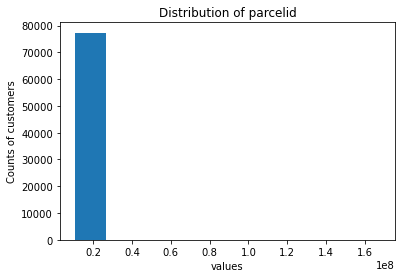

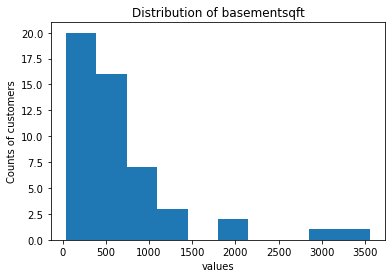

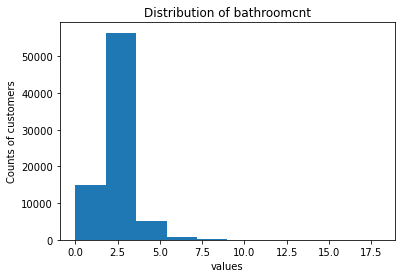

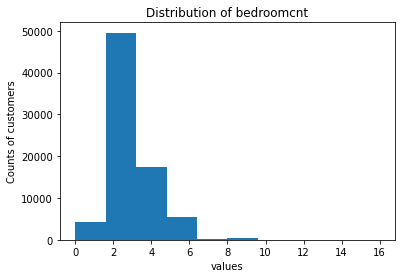

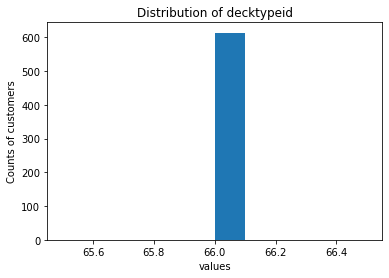

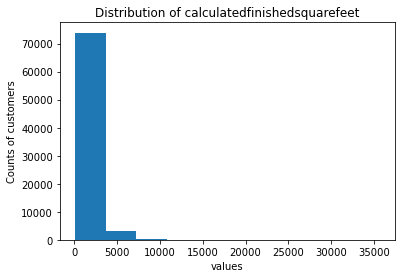

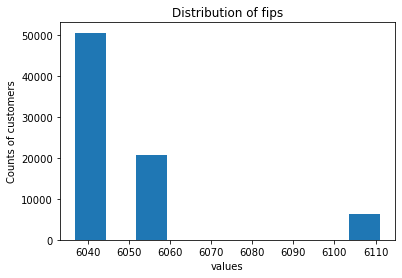

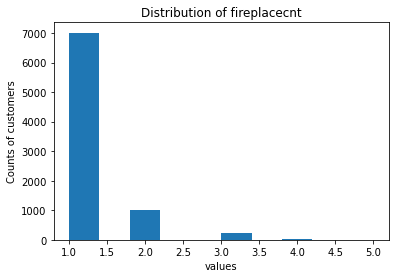

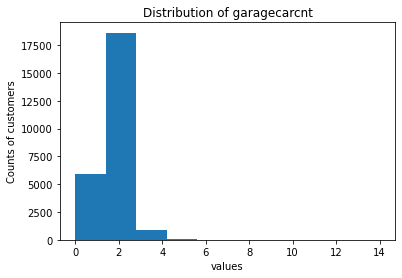

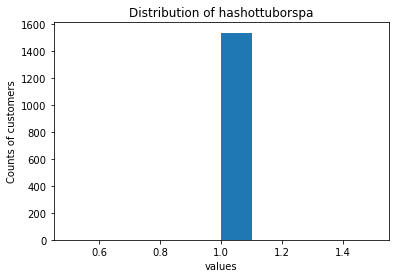

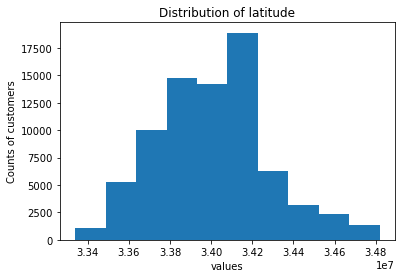

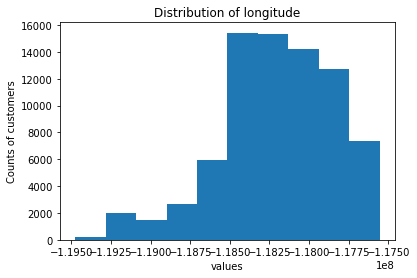

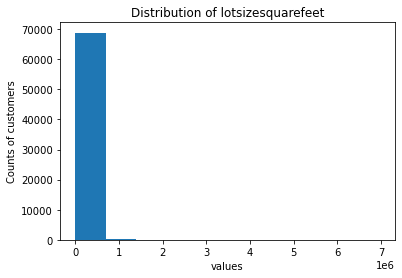

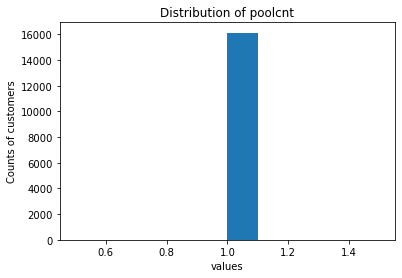

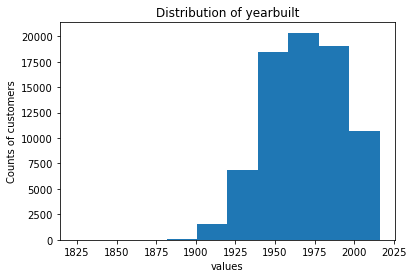

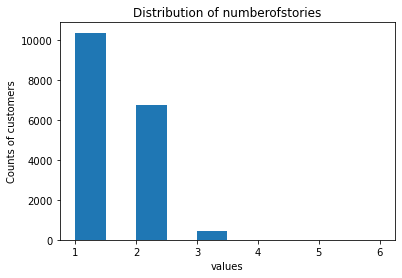

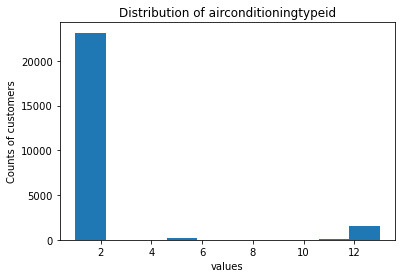

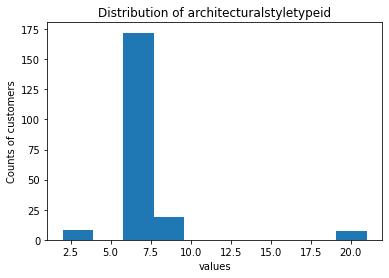

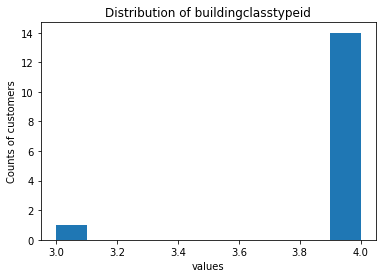

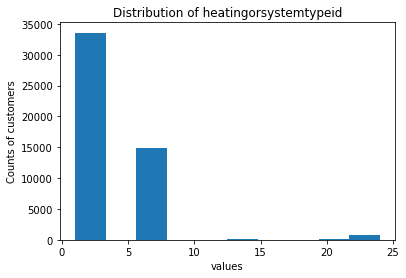

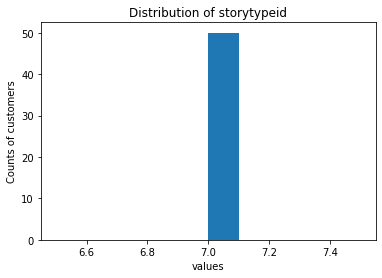

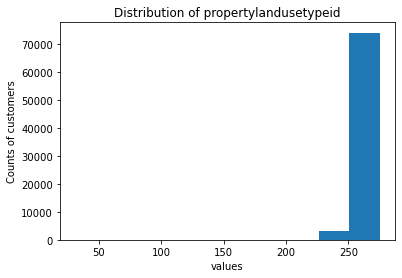

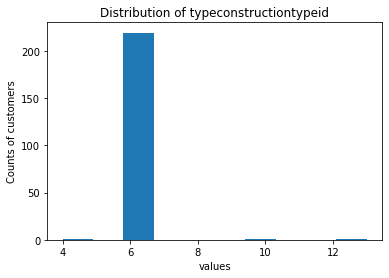

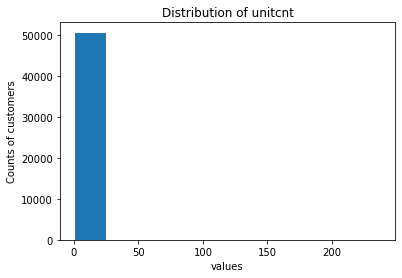

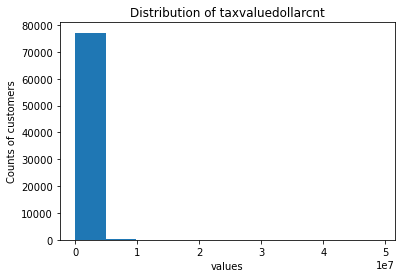

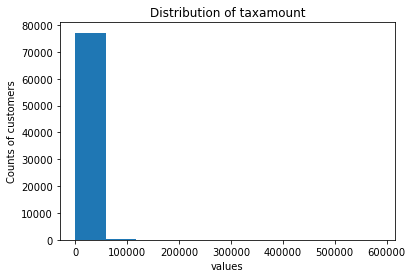

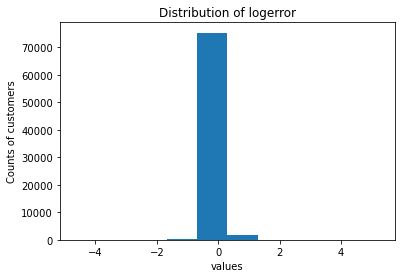

In [23]:
#distrubution of data
p.distribution(df1)

**3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.**

In [24]:
a.miss_dup_values(df1)

Your selected dataframe has 35 columns.
There are 25 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclassdesc,77366,100.0
buildingclasstypeid,77366,100.0
basementsqft,77331,99.9
storydesc,77331,99.9
storytypeid,77331,99.9
architecturalstyledesc,77175,99.7
architecturalstyletypeid,77175,99.7
typeconstructiondesc,77159,99.7
typeconstructiontypeid,77159,99.7
decktypeid,76767,99.2


**4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.**

In [25]:
def nulls_by_row(df):
    '''
    akes in a dataframe and returns a dataframe with 3 columns: 
    the number of columns missing, percent of columns missing, and number of rows with n columns missing
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [26]:
nulls_by_row (df1)

,num_cols_missing,percent_cols_missing,num_rows
0,8,22.857142857142858,1
1,9,25.71428571428571,24
2,10,28.57142857142857,75
3,11,31.428571428571427,56
4,12,34.285714285714285,188
5,13,37.142857142857146,250
6,14,40.0,7836
7,15,42.857142857142854,15061
8,16,45.714285714285715,7615
9,17,48.57142857142857,28234


## Prepare 

**1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.**

In [27]:
#lest see the columns that help me to identify single unit properties
df1[['parcelid', 'bedroomcnt', 'bathroomcnt', 'propertylandusedesc', 'calculatedfinishedsquarefeet','unitcnt']].head()


,parcelid,bedroomcnt,bathroomcnt,propertylandusedesc,calculatedfinishedsquarefeet,unitcnt
0,14297519,4.0,3.5,Single Family Residential,3100.0,NaN
1,17052889,2.0,1.0,Single Family Residential,1465.0,NaN
2,14186244,3.0,2.0,Single Family Residential,1243.0,NaN
3,12177905,4.0,3.0,Single Family Residential,2376.0,1.0
4,10887214,3.0,3.0,Condominium,1312.0,1.0


In [28]:
#check the values for propertylanduse
df1.propertylandusedesc.value_counts()

Single Family Residential                     52320
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [29]:
#this list has all types of single unit properties that I want to use
single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]


In [30]:
#use isin() to  get the all the properties of this type
df1['propertylandusedesc'].isin(single).head()

0     True
1     True
2     True
3     True
4    False
Name: propertylandusedesc, dtype: bool

In [31]:
#checking the condition
df1[['unitcnt']][(df1['unitcnt'] == 1) | (df1['unitcnt'] == 'NaN')].value_counts()

unitcnt
1.0        47293
dtype: int64

In [32]:
#checking if we get nulls
df1[['unitcnt']][(df1['unitcnt'] == 1) | (df1['unitcnt'].isnull())].isnull().sum()

unitcnt    26818
dtype: int64

In [33]:
#create a mask
single_mask = df1['propertylandusedesc'].isin(single)

In [34]:
#using that mask and also addind a condition
df1[single_mask | (df1['unitcnt'] == 1)].shape

(65937, 35)

In [35]:
#using that mask and also add  a condition
df_single = df1[single_mask & ((df1['unitcnt'] == 1) | (df1['unitcnt'].isnull()))]

In [36]:
df_single.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,storydesc,propertylandusetypeid,propertylandusedesc,typeconstructiontypeid,typeconstructiondesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,1023282.0,11013.72,0.025595,2017-01-01
1,17052889,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,464000.0,5672.48,0.055619,2017-01-01
2,14186244,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,564778.0,6488.30,0.005383,2017-01-01
3,12177905,NaN,3.0,4.0,NaN,2376.0,6037.0,NaN,NaN,NaN,...,None,261.0,Single Family Residential,NaN,None,1.0,145143.0,1777.51,-0.103410,2017-01-01
6,12095076,NaN,3.0,4.0,NaN,2962.0,6037.0,NaN,NaN,NaN,...,None,261.0,Single Family Residential,NaN,None,1.0,773303.0,9516.26,-0.001011,2017-01-01


In [37]:
df_single.shape

(52350, 35)

In [38]:
df_single['unitcnt'].value_counts(dropna=False)

1.0    33734
NaN    18616
Name: unitcnt, dtype: int64

In [39]:
#checking if we get unitcnt >1
df_single[['propertylandusedesc']][df_single['unitcnt'] > 1]

,propertylandusedesc


## remove outliers

first we are going to check outliers for ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', taxvaluedollarcnt]

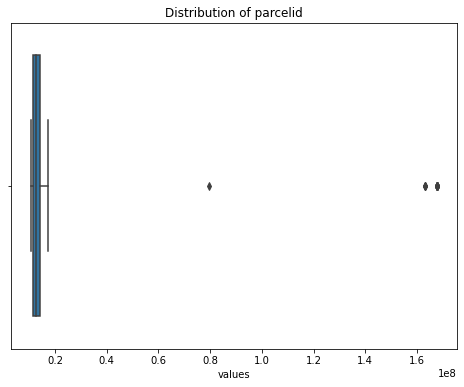

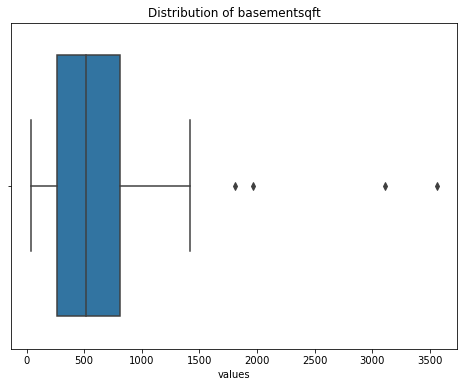

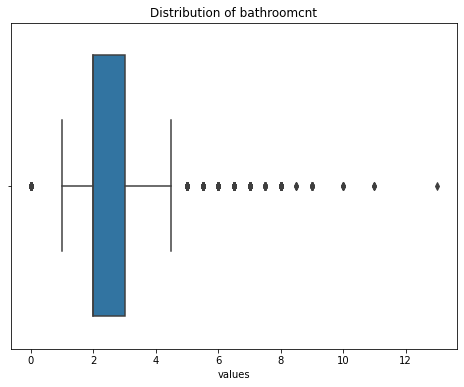

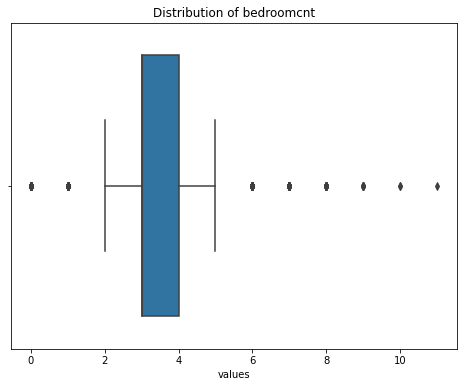

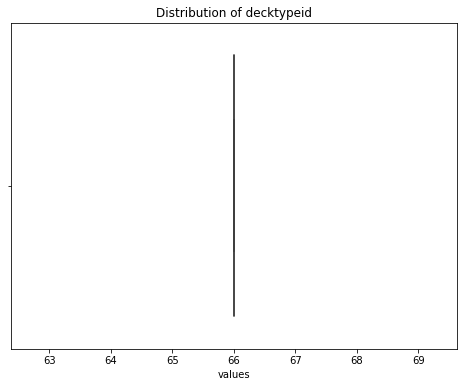

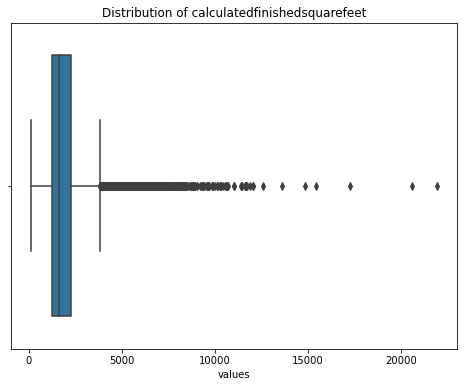

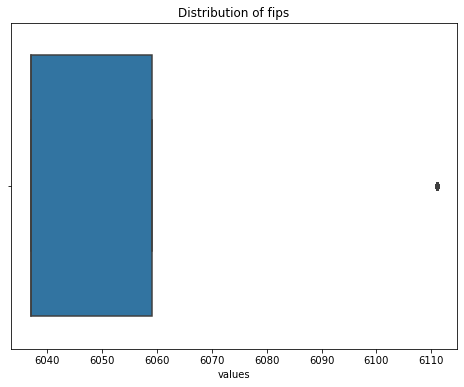

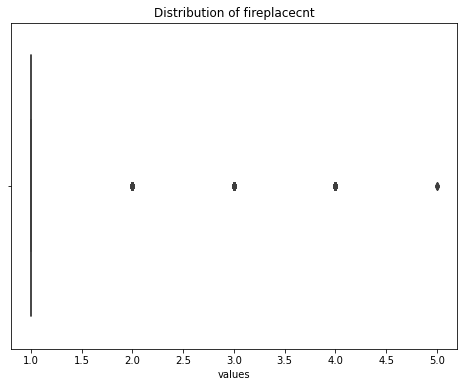

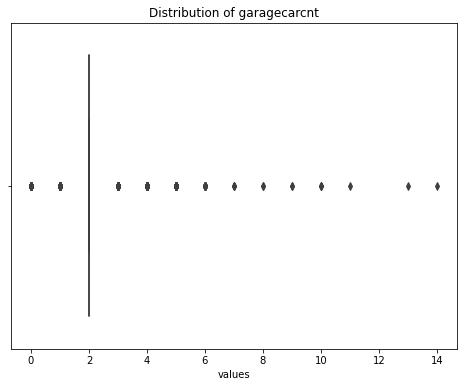

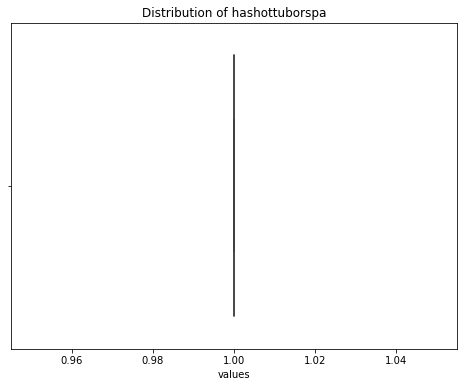

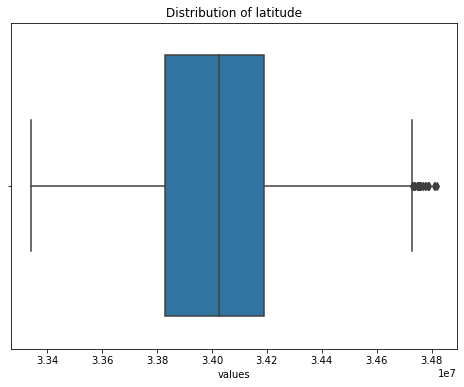

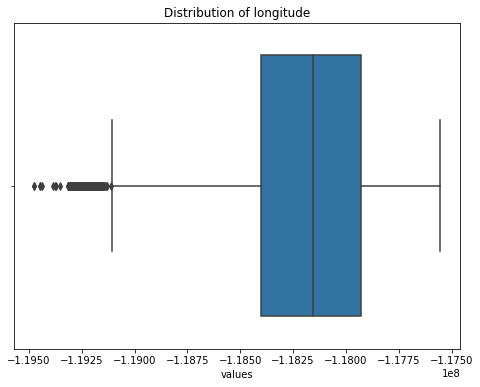

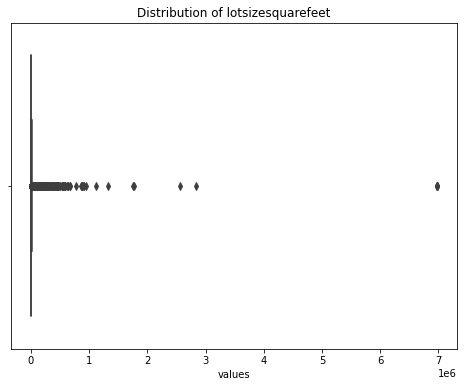

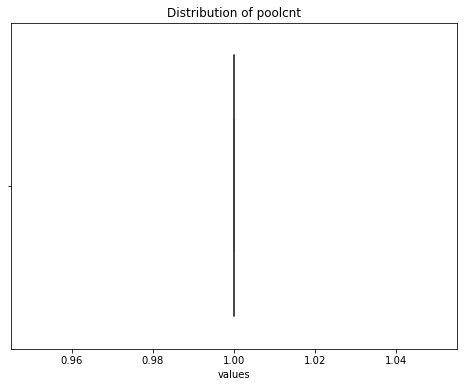

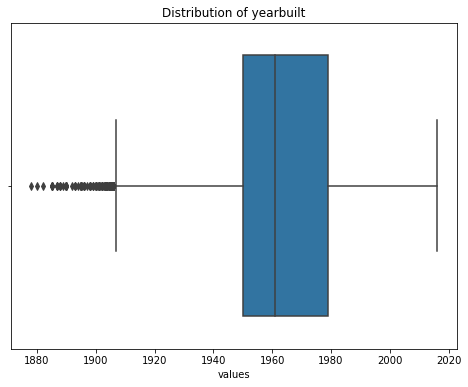

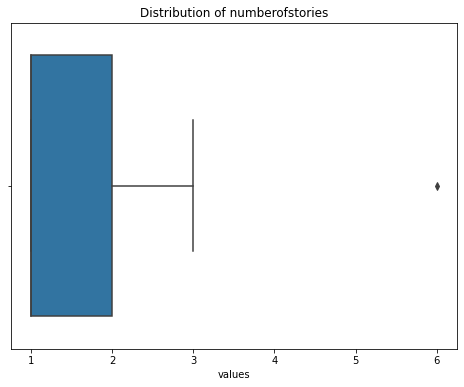

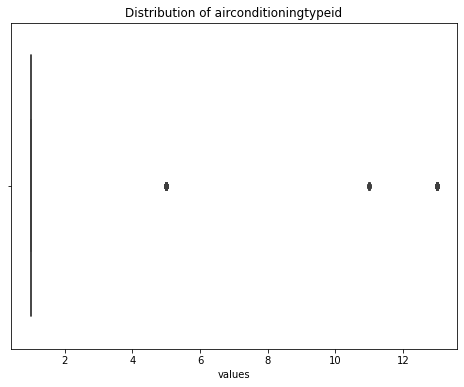

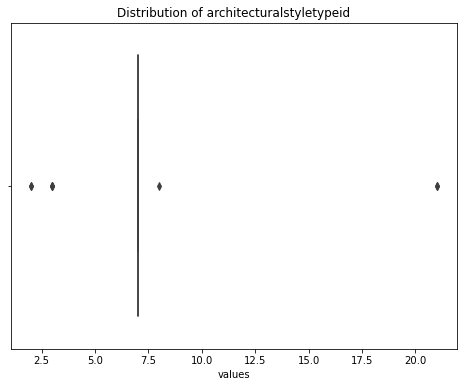

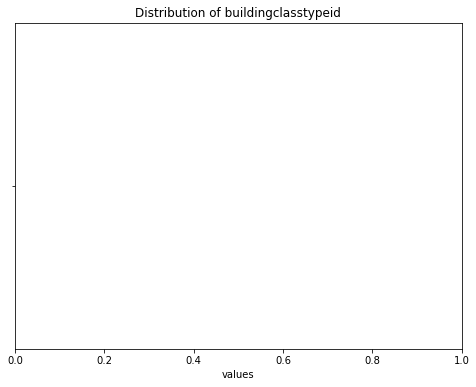

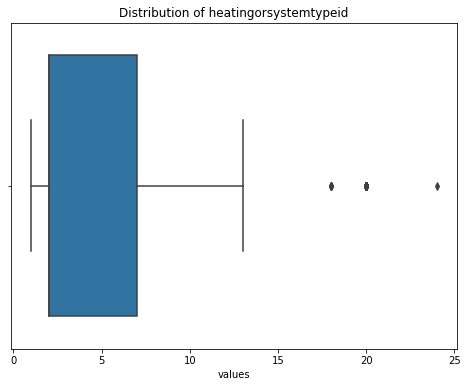

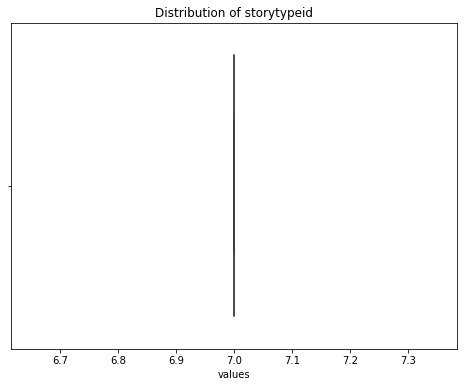

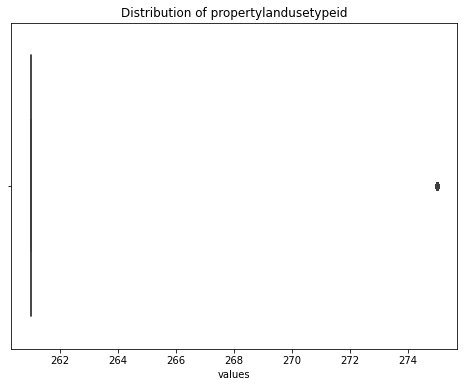

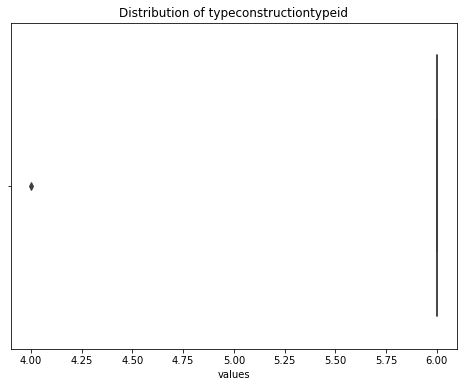

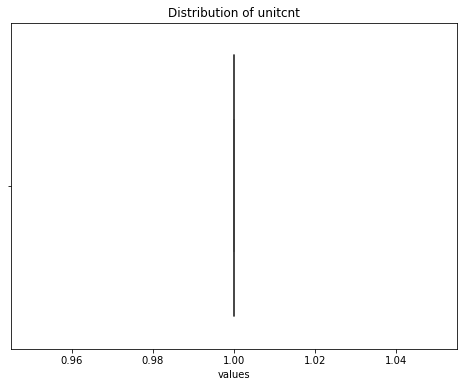

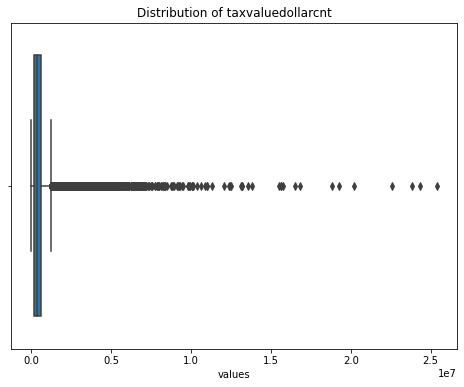

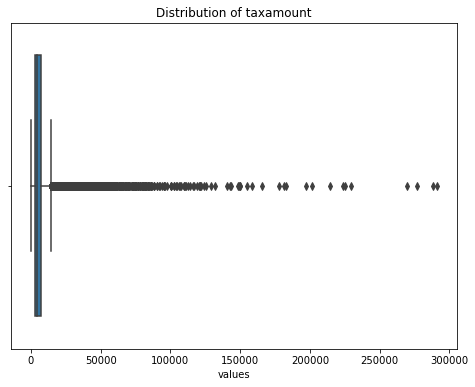

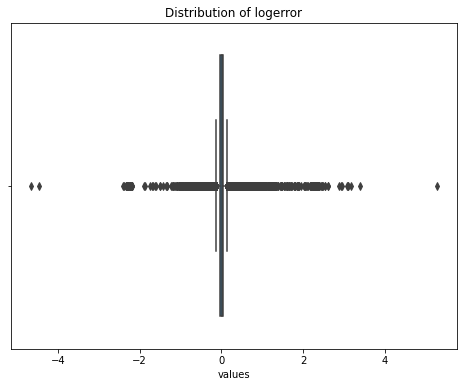

In [40]:
p.distribution_boxplot(df_single)

In [41]:
df_single.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,storydesc,propertylandusetypeid,propertylandusedesc,typeconstructiontypeid,typeconstructiondesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,1023282.0,11013.72,0.025595,2017-01-01
1,17052889,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,464000.0,5672.48,0.055619,2017-01-01
2,14186244,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,NaN,...,None,261.0,Single Family Residential,NaN,None,NaN,564778.0,6488.30,0.005383,2017-01-01
3,12177905,NaN,3.0,4.0,NaN,2376.0,6037.0,NaN,NaN,NaN,...,None,261.0,Single Family Residential,NaN,None,1.0,145143.0,1777.51,-0.103410,2017-01-01
6,12095076,NaN,3.0,4.0,NaN,2962.0,6037.0,NaN,NaN,NaN,...,None,261.0,Single Family Residential,NaN,None,1.0,773303.0,9516.26,-0.001011,2017-01-01


In [42]:
df_single.shape

(52350, 35)

In [43]:
col_list =['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']

In [44]:
def remove_outliers(df,  col_list , k=1.5):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[f'{col}'].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [45]:
# k = 1.5 is an standard

In [46]:
df_single = remove_outliers(df_single,  col_list, 1.5)

In [47]:
df_single.shape

(48246, 35)

**2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).**
- The input:
    - A dataframe
        -A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
    - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.


In [48]:
df1.shape

(77381, 35)

In [49]:
df_single.shape

(48246, 35)

In [50]:
a.miss_dup_values(df_single)

Your selected dataframe has 35 columns.
There are 24 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclassdesc,48246,100.0
buildingclasstypeid,48246,100.0
basementsqft,48209,99.9
storydesc,48209,99.9
storytypeid,48209,99.9
architecturalstyletypeid,48181,99.9
architecturalstyledesc,48181,99.9
typeconstructiontypeid,48175,99.9
typeconstructiondesc,48175,99.9
decktypeid,47964,99.4


In [51]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    '''
    takes in a df and a minimum proportion  acceptable nulls in each column and row
    '''
    
    # get minimum acceptable nulls in each column
    threshold = int(round(prop_required_columns * len(df.index),0))
    # drop columns based on threshold number
    df = df.dropna(axis=1, thresh=threshold)
     # get minimum acceptable nulls in each row
    threshold = int(round(prop_required_row * len(df.columns),0))
    # drop rows based on threshold number
    df = df.dropna(axis=0, thresh=threshold)
    

     
    return df

In [52]:
df_single= handle_missing_values(df_single, prop_required_columns=0.5, prop_required_row=0.75)

In [53]:
a.miss_dup_values(df_single)

Your selected dataframe has 18 columns.
There are 7 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
unitcnt,16835,34.9
heatingorsystemtypeid,16701,34.6
heatingorsystemdesc,16701,34.6
lotsizesquarefeet,250,0.5
yearbuilt,24,0.0
taxamount,4,0.0
taxvaluedollarcnt,1,0.0


**3. Decide how to handle the remaining missing values:**

- Fill with constant value.
- Impute with mean, median, mode.
- Drop row/column

In [54]:
#we can see there are some columns that have a very low missing values, I create a function to drop this low percentage of values

In [55]:
#I'm calculating the percentage of missing values
((100 * df_single.isnull().sum() / len(df_single))) 

parcelid                         0.000000
bathroomcnt                      0.000000
bedroomcnt                       0.000000
calculatedfinishedsquarefeet     0.000000
fips                             0.000000
latitude                         0.000000
longitude                        0.000000
lotsizesquarefeet                0.518178
yearbuilt                        0.049745
heatingorsystemtypeid           34.616341
heatingorsystemdesc             34.616341
propertylandusetypeid            0.000000
propertylandusedesc              0.000000
unitcnt                         34.894084
taxvaluedollarcnt                0.002073
taxamount                        0.008291
logerror                         0.000000
transactiondate                  0.000000
dtype: float64

In [56]:
# with this condition I will get the columns that has less that 1% of missing values
lis =((100 * df_single.isnull().sum() / len(df_single))> 0) &  ((100 * df_single.isnull().sum() / len(df_single))< 1)

In [57]:
#this is the list of columns with misisng values <1%
col_drop = list(lis[lis == True].index)

In [58]:
col_drop

['lotsizesquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']

In [59]:
missing = a.miss_dup_values(df_single)
missing

Your selected dataframe has 18 columns.
There are 7 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
unitcnt,16835,34.9
heatingorsystemtypeid,16701,34.6
heatingorsystemdesc,16701,34.6
lotsizesquarefeet,250,0.5
yearbuilt,24,0.0
taxamount,4,0.0
taxvaluedollarcnt,1,0.0


In [60]:
#getting only the columns with missing values
missing.index.to_list()

['unitcnt',
 'heatingorsystemtypeid',
 'heatingorsystemdesc',
 'lotsizesquarefeet',
 'yearbuilt',
 'taxamount',
 'taxvaluedollarcnt']

In [61]:
#checking the columns that have missing values
df_single[missing.index.to_list()].describe().T

,count,mean,std,min,25%,50%,75%,max
unitcnt,31411.0,1.000000,0.000000,1.00,1.0000,1.000,1.000,1.00
heatingorsystemtypeid,31545.0,4.022951,2.558802,1.00,2.0000,2.000,7.000,24.00
lotsizesquarefeet,47996.0,10233.984103,87848.657735,236.00,5507.0000,6743.000,8378.000,6971010.00
yearbuilt,48222.0,1962.399216,22.138944,1878.00,1950.0000,1960.000,1977.000,2016.00
taxamount,48242.0,5437.841941,4843.696883,49.18,2562.7825,4446.105,6778.635,129365.37
taxvaluedollarcnt,48245.0,441913.314706,419451.707299,1000.00,184690.0000,355000.000,566927.000,11000000.00


In [62]:
#for calculatedfinishedsquarefeet I will check if there any other house with the same # bedrooms and bathrooms
df_single[df_single['calculatedfinishedsquarefeet'].isnull()]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,heatingorsystemtypeid,heatingorsystemdesc,propertylandusetypeid,propertylandusedesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate


In [63]:
#checking if there are another properties with same bedrooms, bathrooms and lotsize

In [64]:
df_single[(df_single['bathroomcnt'] == 4.5 ) & (df_single['bedroomcnt'] == 5 ) & (df_single['lotsizesquarefeet'] > 200000)]

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,heatingorsystemtypeid,heatingorsystemdesc,propertylandusetypeid,propertylandusedesc,unitcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate


** I decide to drop those rows**

In [65]:
#df_clean.dropna(axis=0, subset=['calculatedfinishedsquarefeet'], inplace = True)

In [66]:
#df_clean[df_clean['calculatedfinishedsquarefeet'].isnull()]

**I decided to create a function that  remove the rows that has columuns with missing values less than 1%**

In [67]:
def dropp_low_missing_values(df, per = 1 ):
    '''
    takes in a df and the percentage that you want to drop of rows. the defautl value is 1%
     remove the rows that has columuns with missing values less than 1%**
    '''
    
    #drop rows with null values < per %
    lis =((100 * df.isnull().sum() / len(df))> 0) &  ((100 * df.isnull().sum() / len(df))< per)
    col_drop = list(lis[lis == True].index)
    df = df.dropna(axis=0, subset = col_drop)
    
    return df

In [68]:
df_single.shape

(48246, 18)

In [69]:
df_clean= dropp_low_missing_values(df_single, 1)

In [70]:
df_clean.shape

(47968, 18)

In [71]:
#for  unitcnt I will add 1 because it is single unit property

In [72]:
df_clean['unitcnt'].fillna(1, inplace= True)

In [73]:
df_clean['unitcnt'].isnull().sum()

0

In [74]:
#for the rest I will split before impute 

In [75]:
a.miss_dup_values(df_clean)

Your selected dataframe has 18 columns.
There are 2 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
heatingorsystemtypeid,16648,34.7
heatingorsystemdesc,16648,34.7


In [76]:
train, validate,  test = p.split_data(df_clean)

train -> (26861, 18)
validate -> (11513, 18)
test -> (9594, 18)


In [77]:
# lets check heatingorsystemtypeid and  heatingorsystemtypeid. they have the same information
train['heatingorsystemtypeid'].value_counts()

2.0     10492
7.0      6791
6.0       285
20.0       33
13.0        9
1.0         5
18.0        3
24.0        1
Name: heatingorsystemtypeid, dtype: int64

In [78]:
train['heatingorsystemdesc'].value_counts()

Central       10492
Floor/Wall     6791
Forced air      285
Solar            33
None              9
Baseboard         5
Radiant           3
Yes               1
Name: heatingorsystemdesc, dtype: int64

In [79]:
#both columns have the same info I will drop heatingorsystemdesc

In [80]:
#I will add with the most frequent value using simple imputer

In [81]:
imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')

In [82]:
imputer = imputer.fit(train[['heatingorsystemtypeid']])

In [83]:
train[['heatingorsystemtypeid']] = imputer.transform(train[['heatingorsystemtypeid']])

validate[['heatingorsystemtypeid']] = imputer.transform(validate[['heatingorsystemtypeid']])

test[['heatingorsystemtypeid']] = imputer.transform(test[['heatingorsystemtypeid']])

In [84]:
def fill_nan(train, validate, test, cols,  strategy = 'most_frequent'):
    
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values = np.nan, strategy= strategy)
    imputer = imputer.fit(train[cols])
    
    train[cols] = imputer.transform(train[cols])
    validate[cols] = imputer.transform(validate[cols])
    test[cols] = imputer.transform(test[cols])
    
    return train, validate, test

In [85]:
# Validate that there are no longer any Null values in heatingorsystemtypeid
train.heatingorsystemtypeid.value_counts(dropna=False)

2.0     19734
7.0      6791
6.0       285
20.0       33
13.0        9
1.0         5
18.0        3
24.0        1
Name: heatingorsystemtypeid, dtype: int64

In [86]:
#let's see the columns with missing values

In [87]:
miss = a.miss_dup_values(train)
miss

Your selected dataframe has 18 columns.
There are 1 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
heatingorsystemdesc,9242,34.4


### wrangle_zillow.py
**Functions of the work above needed to acquire and prepare a new sample of data.**

In [109]:
def wrangle_zillow ( sql_query, prop_required_columns=0.5, prop_required_row=0.75, strategy = 'most_frequent'):
    
    #acquire data
    df= a.get_data_from_sql('zillow',sql_query)
    
    
    #getting the latest transactions 
    df1 = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')
   
    
    #this list has all types of single unit properties
    single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]
    #create a mask
    single_mask = df1['propertylandusedesc'].isin(single)
    #using that mask and also add  a condition
    df_single = df1[single_mask & ((df1['unitcnt'] == 1) | (df1['unitcnt'].isnull()))]
    
    
    #remove outliers 
    col_list =['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']
    df_single = p.remove_outliers(df_single, col_list,   k=1.5)
    

    #missing values
    df_clean = handle_missing_values(df_single, prop_required_columns, prop_required_row)

    #missing low values
    df_clean = dropp_low_missing_values(df_clean)

    #drop duplicated rows
    df_clean= df_clean.drop(columns = 'heatingorsystemdesc')
    
    #fill missing values in unitcnt
    df_clean['unitcnt'].fillna(1, inplace= True)
    print('df  -->', df_clean.shape)
    
    #split
    train, validate,  test = p.split_data(df_clean)
    
    #fill nan using simple imputer
    cols = ['heatingorsystemtypeid']
    train, validate, test = fill_nan(train, validate, test, cols,  strategy = 'most_frequent')
    
    

    
    return train, validate, test
  

In [110]:
train, validate, test = wrangle_zillow ( sql_query, prop_required_columns=0.5, prop_required_row=0.75)

df  --> (47968, 17)
train -> (26861, 17)
validate -> (11513, 17)
test -> (9594, 17)


____________________________

## Testing my wrangle_zillow funcion

In [111]:
import wrangle_zillow as wz

In [112]:
train, validate, test = wz.wrangle_zillow()

df --> (47968, 17)
train -> (26861, 17)
validate -> (11513, 17)
test -> (9594, 17)


____________________________